In [1]:
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
import torch.utils.data as Data
import matplotlib as mpl
import scipy.io as sio
import numpy as np
import argparse
import h5py
import time

import torch
import torch.nn as nn
from torch import optim
import torch.utils.data as Data
import torch.nn.functional as F
from torchsummary import summary
import torch.backends.cudnn as cudnn
from sklearn.metrics import confusion_matrix

from auxiliary_classifier import auxiliary_test_epoch
from auxiliary_classifier import auxiliary_train_epoch
from auxiliary_classifier import auxiliary_valid_epoch

from data_prepare import mirror_hsi
from Utils import ActivationOutputData, safe_norm
from caps_vit import CapsViT, Margin_Recon_Loss
from data_prepare import choose_train_and_test_number
from Utils import output_metric, plot_confusion_matrix
from Utils import train_epoch, test_epoch, valid_epoch
from data_prepare import choose_train_and_test_proportion
from Utils import list_to_colormap, classification_map, print_args

from einops import rearrange, repeat

%matplotlib inline

In [2]:
parser = argparse.ArgumentParser("HSI")
parser.add_argument('--dataset', choices=['Chikusei', 'Pavia', 'KSC', 'HU2013'], default='KSC', help='dataset to use')
parser.add_argument('--flag_test', choices=['test', 'train'], default='train', help='testing mark')
parser.add_argument('--mode', choices=['ViT', 'CAF'], default='CAF', help='mode choice')
parser.add_argument('--seed', type=int, default=0, help='number of seed')
parser.add_argument('--batch_size', type=int, default=32, help='number of batch size')
parser.add_argument('--patch_size', type=int, default=9, help='size of patches')
parser.add_argument('--band_patches', type=int, default=1, help='number of related band')
parser.add_argument('--epoches', type=int, default=200, help='epoch number')
parser.add_argument('--learning_rate', type=float, default=5e-4, help='learning rate')
parser.add_argument('--gamma', type=float, default=0.9, help='gamma')
parser.add_argument('--weight_decay', type=float, default=0, help='weight_decay')
parser.add_argument('--train_proportion', type=float, default=0.1, help='num_train_per_class')
args = parser.parse_args(args=[])

In [4]:
# prepare data
if args.dataset == 'Chikusei':
    data = h5py.File('./dataset/Chikusei.mat', 'r')['chikusei']
    data = np.array(data)
    data = np.transpose(data, (2, 1, 0))
    label = sio.loadmat('./dataset/Chikusei_gt.mat')['GT'][0][0][0]
elif args.dataset == 'HU2013':
    data = sio.loadmat('./dataset/Houston.mat')['Houston']
    label = sio.loadmat('./dataset/Houston_gt.mat')['Houston_gt']
elif args.dataset == 'Pavia':
    data = sio.loadmat('./dataset/PaviaU.mat')['paviaU']
    label = sio.loadmat('./dataset/PaviaU_gt.mat')['paviaU_gt']
elif args.dataset == 'KSC':
    data = sio.loadmat('./dataset/KSC.mat')['KSC']
    label = sio.loadmat('./dataset/KSC_gt.mat')['KSC_gt']
else:
    raise ValueError("Unknown dataset")
    
num_classes = np.max(label)
print('The class numbers of the HSI data is:', num_classes)

The class numbers of the HSI data is: 13


In [5]:
shapeor = data.shape
data = data.reshape(np.prod(data.shape[:2]), np.prod(data.shape[2:]))

std_scaler = StandardScaler()
std_data = std_scaler.fit_transform(data)
data = std_data.reshape(shapeor)

In [6]:
total_pos_train, total_pos_test, total_pos_true, number_train, number_test, number_true = \
choose_train_and_test_proportion(label, args.train_proportion)
#  Don't forget to modify the choose_train_and_test_proportion function in the data_prepare module.

# data size
height, width, band = data.shape
print("height={0}, width={1}, band={2}".format(height, width, band))

height=512, width=614, band=176


In [7]:
# 获取patch的图像数据
def gain_neighborhood_pixel(mirror_image, point, i, patch=5):
    x = point[i, 0]
    y = point[i, 1]
    temp_image = mirror_image[x:(x+patch), y:(y+patch), :]
    return temp_image

In [8]:
def gain_neighborhood_band(x_train, band, band_patch=1, patch=9):
    n = band_patch // 2  # 1
    p = (patch * patch) // 2  # 12
    x_train_reshape = x_train.reshape(x_train.shape[0], patch*patch, band)  # (695, 25, 200)
    x_train_band = np.zeros((x_train.shape[0], patch*patch*band_patch, band), dtype=float)  # (695, 75, 200)
    # 中心区域
    x_train_band[:, patch*patch*n:(n+1)*patch*patch, :] = x_train_reshape 
    # 左边镜像
    for i in range(n):
        if p > 0:
            x_train_band[:, i*patch*patch:(i+1)*patch*patch, :i+1] = x_train_reshape[:, :, band-i-1:]
            x_train_band[:, i*patch*patch:(i+1)*patch*patch, i+1:] = x_train_reshape[:, :, :band-i-1]
        else:
            x_train_band[:, i:(i+1), :(n-i)] = x_train_reshape[:, 0:1, (band-nn+i):]
            x_train_band[:, i:(i+1), (n-i):] = x_train_reshape[:, 0:1, :(band-nn+i)]
    #右边镜像
    for i in range(n):
        if p > 0:
            x_train_band[:, (n+i+1)*patch*patch:(n+i+2)*patch*patch, :band-i-1] = x_train_reshape[:, :, i+1:]
            x_train_band[:, (n+i+1)*patch*patch:(n+i+2)*patch*patch, band-i-1:] = x_train_reshape[:, :, :i+1]
        else:
            x_train_band[:, (n+1+i):(n+2+i), (band-i-1):] = x_train_reshape[:, 0:1, :(i+1)]
            x_train_band[:, (n+1+i):(n+2+i), :(band-i-1)] = x_train_reshape[:, 0:1, (i+1):]
    return x_train_band

In [9]:
# 汇总训练数据和测试数据
def train_and_test_data(mirror_image, band, train_point, test_point, true_point, patch=9, band_patch=1):
    x_train = np.zeros((train_point.shape[0], patch, patch, band), dtype=float)  # (695, 5, 5, 200)
    x_test = np.zeros((test_point.shape[0], patch, patch, band), dtype=float)  # (9671, 5, 5, 200)
    x_true = np.zeros((true_point.shape[0], patch, patch, band), dtype=float)
    for i in range(train_point.shape[0]):
        x_train[i] = gain_neighborhood_pixel(mirror_image, train_point, i, patch)
    for j in range(test_point.shape[0]):
        x_test[j,:,:,:] = gain_neighborhood_pixel(mirror_image, test_point, j, patch)
    for k in range(true_point.shape[0]):
        x_true[k,:,:,:] = gain_neighborhood_pixel(mirror_image, true_point, k, patch)
    print("x_train shape = {}, type = {}".format(x_train.shape,x_train.dtype))
    print("x_test  shape = {}, type = {}".format(x_test.shape,x_test.dtype))
    print("x_true  shape = {}, type = {}".format(x_true.shape,x_test.dtype))
    print("**************************************************")
    x_train_band = gain_neighborhood_band(x_train, band, band_patch, patch)
    x_test_band = gain_neighborhood_band(x_test, band, band_patch, patch)
    x_true_band = gain_neighborhood_band(x_true, band, band_patch, patch)
    print("x_train_band shape = {}, type = {}".format(x_train_band.shape, x_train_band.dtype))
    print("x_test_band  shape = {}, type = {}".format(x_test_band.shape, x_test_band.dtype))
    print("x_true_band  shape = {}, type = {}".format(x_true_band.shape, x_true_band.dtype))
    print("**************************************************")
    return x_train_band, x_test_band, x_true_band

In [10]:
# 标签y_train, y_test
def train_and_test_label(number_train, number_test, number_true, num_classes):
    y_train = []
    y_test = []
    y_true = []
    for i in range(num_classes):
        for j in range(number_train[i]):
            y_train.append(i)
        for k in range(number_test[i]):
            y_test.append(i)
        for n in range(number_true[i]):
            y_true.append(i)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    y_true = np.array(y_true)
    print("y_train: shape = {} ,type = {}".format(y_train.shape,y_train.dtype))
    print("y_test: shape = {} ,type = {}".format(y_test.shape,y_test.dtype))
    print("y_true: shape = {} ,type = {}".format(y_true.shape,y_true.dtype))
    print("**************************************************")
    return y_train, y_test, y_true

In [11]:
mirror_data = mirror_hsi(height, width, band, data, patch_size=args.patch_size)

x_train_band, x_test_band, x_true_band = train_and_test_data(mirror_data, band, total_pos_train, 
                                                             total_pos_test, total_pos_true)

y_train, y_test, y_true = train_and_test_label(number_train, number_test, number_true, num_classes)

**************************************************
patch_size is : 9
mirror_data shape : [520, 622, 176]
**************************************************
x_train shape = (528, 9, 9, 176), type = float64
x_test  shape = (4683, 9, 9, 176), type = float64
x_true  shape = (5211, 9, 9, 176), type = float64
**************************************************
x_train_band shape = (528, 81, 176), type = float64
x_test_band  shape = (4683, 81, 176), type = float64
x_true_band  shape = (5211, 81, 176), type = float64
**************************************************
y_train: shape = (528,) ,type = int64
y_test: shape = (4683,) ,type = int64
y_true: shape = (5211,) ,type = int64
**************************************************


In [12]:
# load data
x_train = torch.from_numpy(x_train_band.transpose(0, 2, 1)).type(torch.FloatTensor)  # (695, 200, 75)
y_train = torch.from_numpy(y_train).type(torch.LongTensor)  # (695)
print(x_train.shape, y_train.shape)
Label_train = Data.TensorDataset(x_train, y_train)

x_test = torch.from_numpy(x_test_band.transpose(0,2,1)).type(torch.FloatTensor) # [9671, 200, 75]
y_test = torch.from_numpy(y_test).type(torch.LongTensor) # [9671]
Label_test = Data.TensorDataset(x_test, y_test)

x_true = torch.from_numpy(x_true_band.transpose(0,2,1)).type(torch.FloatTensor)
y_true = torch.from_numpy(y_true).type(torch.LongTensor)
Label_true = Data.TensorDataset(x_true, y_true)

train_loader = Data.DataLoader(Label_train, batch_size=args.batch_size, shuffle=True)
test_loader = Data.DataLoader(Label_test, batch_size=args.batch_size, shuffle=True)
true_loader = Data.DataLoader(Label_true, batch_size=100, shuffle=False)

torch.Size([528, 176, 81]) torch.Size([528])


## Create Model

In [13]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

In [14]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)  # 在特征维度进行归一化
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

In [15]:
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim), 
            nn.GELU(), 
            nn.Dropout(dropout), 
            nn.Linear(hidden_dim, dim), 
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

In [16]:
class Attention(nn.Module):
    """
    dim_head = 16  注意力的维度
    dim = 64
    heads = 4
    """
    def __init__(self, dim, heads, dim_head, dropout):
        super().__init__()
        inner_dim = dim_head * heads  # 64  多头注意力级联之后的维度，这里有4头注意力
        self.heads = heads  # 4
        self.scale = dim_head ** -0.5  # 16 ** (-0.5) = 0.25
        
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)  # (batch, 201, 64 * 3)
        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),   # 恢复到原始嵌入特征的维度
            nn.Dropout(dropout)
        )
    def forward(self, x, mask=None):
        # x: (batch, 201, 64)
        b, n, _, h = *x.shape, self.heads  # batch, 201, 64, 4
        
        # get qkv tuple: ((batch, 201, 64), (...), (...))
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=h), qkv)  # q, k, v : (batch, 4, 201, 16)
        
        # transpose(k) * q / sqrt(dim_head) -> (batch, head_num, 201, 201)
        dots = torch.einsum('bhid, bhjd->bhij', q, k) * self.scale  # batch matrix multiplication :(batch, 4, 201, 201)
        mask_value = -torch.finfo(dots.dtype).max
        
        # mask value: -inf
        if mask is not None:
            mask = F.pad(mask.flatten(1), (1, 0), value = True)  # 在第0个维度填充元素1.
            assert mask.shape[-1] == dots.shape[-1], 'mask has incorrect dimensions'
            mask = mask[:, None, :] * mask[:, :, None]
            dots.masked_fill_(~mask, mask_value)
            del mask
            
        # softmax normalization -> attention matrix
        attn = dots.softmax(dim=-1)  # (batch, 4, 201, 201)
        # attn * attention matrix -> output
        out = torch.einsum('bhij, bhjd -> bhid', attn, v)  # (batch, 4, 201, 16)
        # cat all output -> (batch, 201, dim_head * heads)
        out = rearrange(out, 'b h n d -> b n (h d)')  # (batch, 201, 64)
        out = self.to_out(out)  # 恢复到原始嵌入特征的维度以进行残差学习
        return out

In [17]:
class Transformer(nn.Module):
    """
    dim: 嵌入特征维数 64
    depth: Transformer中编码器的层数(个数) 5
    heads: 多头注意力机制里面的头数 4
    mlp_dim: Transformer编码器中MLP层的中间隐藏层的维数 8
    dim_head: 注意力的维度
    """
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout, num_channel, mode):
        super().__init__()
        
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout))),
                Residual(PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout)))
            ]))

        self.mode = mode
        self.skipcat = nn.ModuleList([])
        for _ in range(depth-2):
            self.skipcat.append(nn.Conv2d(num_channel+1, num_channel+1, [1, 2], 1, 0))
            
    def forward(self, x, mask=None):
        # x: (batch, 201, 64)
        if self.mode == 'ViT':
            for attn, ff in self.layers:
                x = attn(x, mask=mask)
                x = ff(x)
        elif self.mode == 'CAF':
            last_output = []
            nl = 0
            for attn, ff in self.layers:
                last_output.append(x)
                if nl > 1:
                    x = self.skipcat[nl-2](torch.cat([x.unsqueeze(3), last_output[nl-2].unsqueeze(3)], dim=3)).squeeze(3)
                x = attn(x)
                x = ff(x)
                nl += 1
        return x

In [18]:
class ViT(nn.Module):
    """
    dim: 嵌入特征维数 64
    depth: Transformer中编码器的层数(个数) 5
    heads: 多头注意力机制里面的头数 4 
    mlp_dim: Transformer编码器中MLP层的中间隐藏层的维数 8
    dim_head: 注意力的维度
    """
    def __init__(self, image_size, near_band, num_patches, num_classes, dim, depth, heads, mlp_dim,
                 channels=1, dim_head=16, dropout=0.1, emb_dropout=0.1, mode='ViT'):
        super().__init__()
        patch_dim = image_size ** 2 * near_band  # 75
        
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))  # (1, 201, dim)，dim表示嵌入特征维度
        self.patch_to_embedding = nn.Linear(patch_dim, dim)  # (batch, 200, 64)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))  # (1, 1, 64)
        
        self.dropout = nn.Dropout(emb_dropout)
        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout, num_patches, mode)
        
        self.to_latent = nn.Identity()
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim), 
            nn.Linear(dim, num_classes)
        )
        
    def forward(self, x, mask=None):
        # x: (batch, patch_num, patch*patch*near_band) (batch, 200, 75)
        
        ## embedding every patch vector to embedding size: (batch, patch_num, embedding_size)
        x = self.patch_to_embedding(x)  # (batch, 200, 64)
        b, n, _ = x.shape
        
        # add position embedding
        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b=b)  # (batch, 1, 64(dim))
        x = torch.cat((cls_tokens, x), dim=1)  # (batch, 201, 64)
        x += self.pos_embedding # (batch, 201, 64)
        x = self.dropout(x)
        
        # transformer: x: (batch, 201, 64(dim)) -> (batch, 201, 64(dim))
        x = self.transformer(x, mask)
        
        # classification: using cls_token output
        x = self.to_latent(x[:, 0])  # x[:, 0]: (batch, 64)
        
        # MLP classification layer
        return self.mlp_head(x)

In [19]:
model = ViT(image_size=args.patch_size, near_band=args.band_patches, num_patches=band, 
            num_classes=num_classes, dim=64, depth=5, heads=4, mlp_dim=8, dropout=0.1, 
            emb_dropout= 0.1, mode = args.mode)

In [20]:
model = model.cuda()
# criterion
criterion = nn.CrossEntropyLoss().cuda()
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args.epoches//10, gamma=args.gamma)

## Valid

In [ ]:
print('start training')
# train model
model.train()
tic = time.time()
for epoch in range(args.epoches):
    # 计算的是移动平均准确率
    train_acc, train_obj, tar_train, pre_train = auxiliary_train_epoch(model, train_loader, criterion, optimizer)
    OA_trian, AA_mean_train, Kappa_train, AA_train = output_metric(tar_train, pre_train)
    print("Epoch: {:03d} train_loss: {:.4f} train_acc: {:.4f}".format(epoch+1, train_obj, train_acc))
    scheduler.step()
    
toc = time.time()
print("Running Time: {:.2f}".format(toc-tic))
print("**************************************************")

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


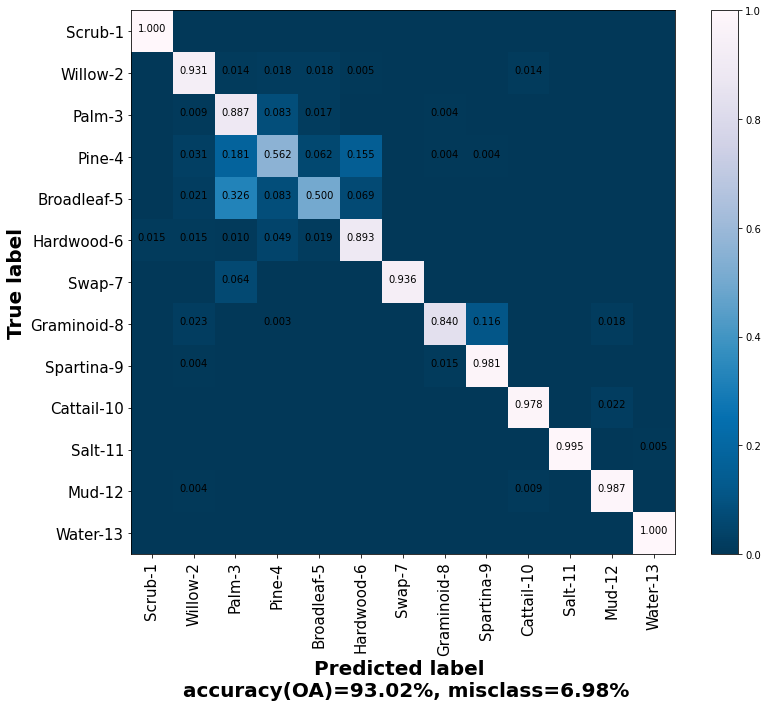

**************************************************
Final result:
OA: 93.02% | AA: 88.38% | Kappa: 0.9222
[1.         0.93119266 0.88695652 0.5619469  0.5        0.89320388
 0.93617021 0.83979328 0.98076923 0.97796143 0.99469496 0.98672566
 1.        ]
**************************************************
Parameter:
dataset: KSC
flag_test: train
mode: CAF
seed: 0
batch_size: 32
patch_size: 9
band_patches: 1
epoches: 200
learning_rate: 0.0005
gamma: 0.9
weight_decay: 0
train_proportion: 0.1
**************************************************


In [21]:
model.eval()
tar_test, pre_test = auxiliary_test_epoch(model, test_loader)  # 收集所有真实标签和预测标签(np.array)
OA_test, AA_mean_test, Kappa_test, AA_test = output_metric(tar_test, pre_test)

# output classification maps
pre_u = auxiliary_valid_epoch(model, true_loader)
prediction_matrix = np.zeros((height, width), dtype=float)  # (512, 614)
for i in range(total_pos_true.shape[0]):
    prediction_matrix[total_pos_true[i, 0], total_pos_true[i, 1]] = pre_u[i] + 1
cm = confusion_matrix(tar_test, pre_test)
plot_confusion_matrix(args.dataset, cm, path='./Confusion_Map_SpectralFormer.pdf')

print("**************************************************")
print("Final result:")
print("OA: {:.2f}% | AA: {:.2f}% | Kappa: {:.4f}".format(OA_test * 100., AA_mean_test*100., Kappa_test))
print(AA_test)
print("**************************************************")
print("Parameter:")
print_args(vars(args))
print("**************************************************")